In [1]:
import talib as ta
import pandas as pd
import numpy as np
from pandas_finance import Equity
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
%matplotlib inline

/Users/mario/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sp500 = Equity("^GSPC").trading_data
sp500['return_t+1'] = sp500['Adj Close'].pct_change(1).shift(-1)
sp500['return_t+3'] = sp500['Adj Close'].pct_change(3).shift(-3)
sp500 = sp500.iloc[:-5]

sp500.head(5)

,High,Low,Open,Close,Volume,Adj Close,return_t+1,return_t+3
Date,,,,,,,,
1990-01-02,359.690002,351.980011,353.399994,359.690002,162070000,359.690002,-0.002586,-0.020823
1990-01-03,360.589996,357.890015,359.690002,358.760010,192330000,358.760010,-0.008613,-0.013853
1990-01-04,358.760010,352.890015,358.760010,355.670013,177000000,355.670013,-0.009756,-0.017010
1990-01-05,355.670013,351.350006,355.670013,352.200012,158530000,352.200012,0.004514,-0.013884
1990-01-08,354.239990,350.540009,352.200012,353.790009,140110000,353.790009,-0.011787,-0.014868


In [3]:
def get_candle_features(df, target='return_t+1', remove_zero_days=False):
    cdl_methods = [m for m in dir(ta) if 'CDL' in m]
    df_cdl = pd.DataFrame(index=df.index)
    for mtd in cdl_methods:
        df_cdl[mtd] = getattr(ta, mtd)(df['Open'], df['High'], df['Low'], df['Close'])
    tgt = df[target]
    
    if remove_zero_days:
        non_zero = df_cdl.sum(axis=1) > 0
        tgt = tgt[non_zero]
        df_cdl = df_cdl[non_zero]
    
    return df_cdl, tgt

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def plot_res(ytrue, base_zero, base_avg, pred, name):
    r1,r2,r3 = rmse(ytrue, base_zero), rmse(ytrue, base_avg), rmse(ytrue, pred)
    r2 = r2 - r1
    r3 = r3 - r1
    name = "Difference from zero baseline - {}".format(name)
    fig = pd.Series([0,r2,r3], index=['Zero', 'Train average', 'Random Forest']).plot.bar(title=name)
    plt.tight_layout()
    plt.savefig(name)

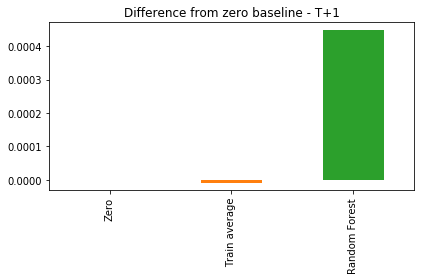

In [4]:

Xtrain, ytrain = get_candle_features(sp500.loc[:"2009-01-01"])
Xval, yval = get_candle_features(sp500.loc["2009-01-01":])

base_avg = np.ones(yval.shape)*ytrain.mean()
base_zero = np.zeros(yval.shape)

mdl = RandomForestRegressor(n_estimators=10000, n_jobs=6)
mdl.fit(Xtrain, ytrain)

p = mdl.predict(Xval)
plot_res(yval, base_zero, base_avg, p, "T+1")

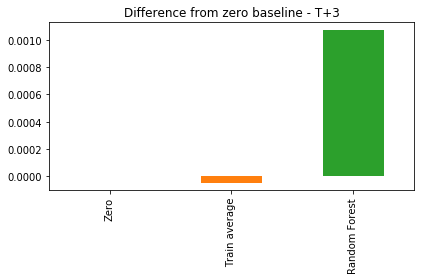

In [5]:
Xtrain, ytrain = get_candle_features(sp500.loc[:"2009-01-01"], 'return_t+3')
Xval, yval = get_candle_features(sp500.loc["2009-01-01":], 'return_t+3')

base_avg = np.ones(yval.shape)*ytrain.mean()
base_zero = np.zeros(yval.shape)

mdl = RandomForestRegressor(n_estimators=10000, n_jobs=6)
mdl.fit(Xtrain, ytrain)

p = mdl.predict(Xval)
plot_res(yval, base_zero, base_avg, p, "T+3")

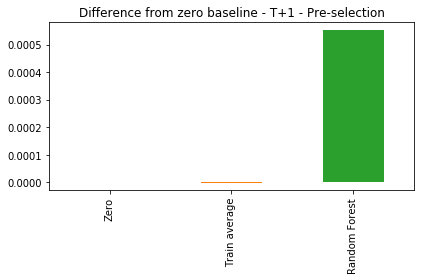

In [6]:
Xtrain, ytrain = get_candle_features(sp500.loc[:"2009-01-01"], 'return_t+1', True)
Xval, yval = get_candle_features(sp500.loc["2009-01-01":], 'return_t+1', True)

base_avg = np.ones(yval.shape)*ytrain.mean()
base_zero = np.zeros(yval.shape)

mdl = RandomForestRegressor(n_estimators=10000, n_jobs=6)
mdl.fit(Xtrain, ytrain)

p = mdl.predict(Xval)
plot_res(yval, base_zero, base_avg, p, "T+1 - Pre-selection")

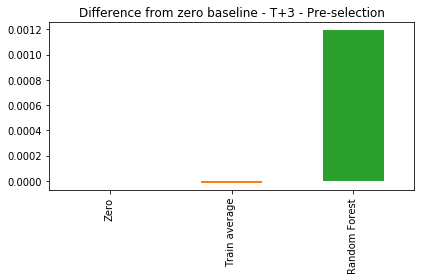

In [7]:
Xtrain, ytrain = get_candle_features(sp500.loc[:"2009-01-01"], 'return_t+3', True)
Xval, yval = get_candle_features(sp500.loc["2009-01-01":], 'return_t+3', True)

base_avg = np.ones(yval.shape)*ytrain.mean()
base_zero = np.zeros(yval.shape)

mdl = RandomForestRegressor(n_estimators=10000, n_jobs=6)
mdl.fit(Xtrain, ytrain)

p = mdl.predict(Xval)
plot_res(yval, base_zero, base_avg, p, "T+3 - Pre-selection")

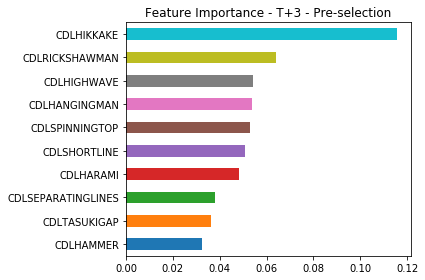

In [8]:
pd.Series(mdl.feature_importances_, Xtrain.columns).sort_values().tail(10).plot.barh(title="Feature Importance - T+3 - Pre-selection")
plt.tight_layout()
plt.savefig("fimp.png")

In [9]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtrain)

shap.summary_plot(shap_values, Xtrain)

/Users/mario/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


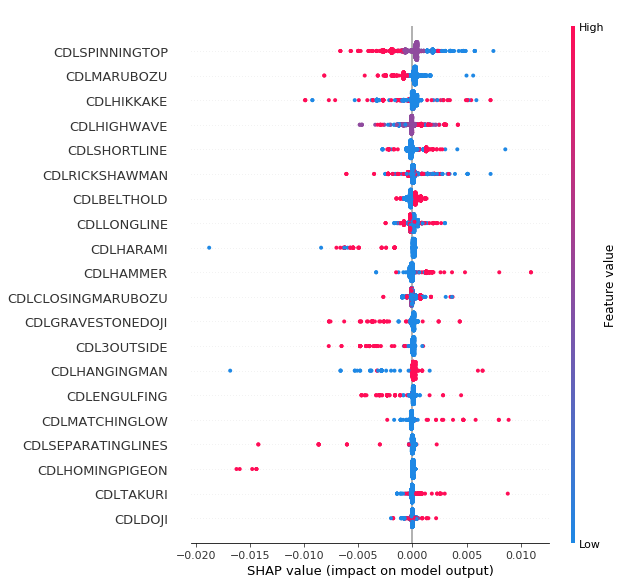

In [10]:
shap.summary_plot(shap_values, Xtrain)

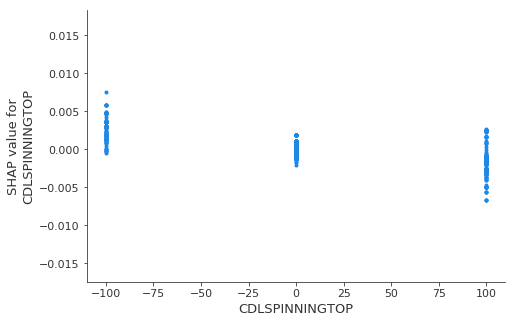

In [13]:
shap.dependence_plot("CDLSPINNINGTOP", shap_values, Xtrain, interaction_index=None)